In [136]:
import numpy as np
import pandas as pd
import random
import statistics as st
import re
import time
import matplotlib.pyplot as plt

class flight:
    # This is a dictionary collection of all fixed threshold information required in a flight
    #capacity
    aircraft_dict = {
        'Boeing737': 120, 
        'Boeing777': 320, 
        'Boeing787': 270,
        'A320': 140,
        'A350': 350,
        'A380': 500}
    
    bus_ticket_profit_dict = {
        'Boeing737': 160*0.9,
        'Boeing777': 140*0.9, 
        'Boeing787': 130*0.9, 
        'A320': 150*0.9,
        'A350':140*0.9,
        'A380':130*0.9}

    eco_ticket_profit_dict = {
        'Boeing737': 100*0.9, 
        'Boeing777': 90*0.9, 
        'Boeing787': 80*0.9, 
        'A320':100*0.9,
        'A350':100*0.9,
        'A380':80*0.9}
    
    def __init__(self, type, capacity, bus_ticket_profit, eco_ticket_profit):
        self.type = type
        self.capacity = capacity
        self.bus_ticket_profit = bus_ticket_profit
        self.eco_ticket_profit = eco_ticket_profit
    
    @classmethod
    # We need to get all information from the flight, including aircraft type, number of seats provided in one flight, and different operation ticket_profit of the flight.
    def get_flight_info(attributes):
        type = input('Please type your aircraft type: ')
        pattern = re.compile(r'(Boeing\s?7[378]7)|(B\s?7[378]7)|(A\s?3[258]0)', re.I)
        pattern=pattern.match(type)

        if pattern:
            if type.lower()[0] == 'b':
                type = 'Boeing' + type[-3:]
            else:
                type= 'A' + type[-3:]
            
            capacity = flight.aircraft_dict[type]
            bus_ticket_profit = flight.bus_ticket_profit_dict[type]
            eco_ticket_profit = flight.eco_ticket_profit_dict[type]

            print('You have selected ',type)
            return attributes(type, capacity, bus_ticket_profit, eco_ticket_profit)
        else:
            print('This is invalid aircraft type. Please try again.')
            return flight.get_flight_info()

# We believe that the demand and no-show comply with binomial distribution

def build_variables(max_overbook, demand_prob, showup_prob, overbook_num, capacity):
# max_overbook is the number of maximum number of overbooking, int type
# demand_prob is the probability of passenger who will buy a ticket, float type
# showup_prob is the probability of passenger who will get on the flight, float type
# overbook_num is the number of how many passenger who acutally bought overbook tickets, int type
# capacity is the maximum seat number limited by the aircraft type, int type
    demand_num = np.random.binomial(max_overbook, demand_prob)
    # The demand_num accord with binomial distribution
    sales_num = demand_num if demand_num <= capacity else capacity + overbook_num
    showup_num = np.random.binomial(sales_num, showup_prob)
    # The demand_num accord with binomial distribution
    no_show_num = sales_num - showup_num

    return sales_num, showup_num


def predict_revenve(sales_num, capacity, showup_num, profit, compensation):
# showup_num: the number of passengers' attendance, int type
# profit: the profit gained from this flight, float data type
# compensation: Compensation for passengers denied to board, int data type
    if showup_num <= capacity:
        revenue = profit * sales_num 
    else:
        revenue= profit * sales_num-compensation*(showup_num-capacity)
    return revenue


def monte_carlo(capacity_all, showup_prob, demand_prob, max_overbook_bus, max_overbook_eco, bus_ticket_profit, eco_ticket_profit):
# we simulate the situation when overbook number is from 0 to 25, and for each scenario, we simulate for 100 times.
# max_overbook_bus: the maximum number of business class overbooking, int type
# max_overbook_eco: the maximum number of economy class overbooking, int type
# bus_ticket_profit: the ticket_profit of each business seat, int type
# eco_ticket_profit: the ticket_profit of each economy seat, int type
    simulation_result = {'revenue_means': [], 'plot': []}
    fare_class = ["business", "economics"]

    for i in range(0, 31):  # overbooking range is 0 and 30
        total_revenue_list = []
        revenue_eco, revenue_bus = [], []
        for n in range(1000):
            overbook_eco = random.randint(0, i + 1)
            overbook_bus = i - overbook_eco
            revenue_list = []
            for class_type in fare_class:
                if class_type == "business":
                    ticket_profit = bus_ticket_profit  # of each seat
                    profit=ticket_profit*0.3 # assume fixed profit rate
                    compensation=ticket_profit*0.2 # assume fixed compensation rate
                    capacity = int(capacity_all*0.15) # assume 15% of seats are for businss class
                    overbook_num = overbook_bus
                    max_overbook = max_overbook_bus
                else:
                    ticket_profit = eco_ticket_profit  # of each seat
                    profit=ticket_profit*0.3
                    compensation=ticket_profit*0.2
                    capacity = capacity_all - capacity
                    overbook_num = overbook_eco
                    max_overbook = max_overbook_eco

                variables = build_variables(max_overbook, demand_prob, showup_prob, overbook_num, capacity)

                sales_num = variables[0]
                showup_num = variables[1]

                revenue = predict_revenve(sales_num, capacity, showup_num, profit, compensation)
                revenue_list.append(revenue)

            revenue_eco.append(revenue_list[0])
            revenue_bus.append(revenue_list[1])
            total_revenue = sum(revenue_list)
            total_revenue_list.append(total_revenue)

        revenue_mean = st.mean(total_revenue_list)
        revenue_mean_eco = st.mean(revenue_eco)
        revenue_mean_bus = st.mean(revenue_bus)
        simulation_result['revenue_means'].append((i, revenue_mean_bus, revenue_mean_eco, revenue_mean))
        simulation_result['plot'].append(revenue_mean)

    return simulation_result

class result:
     
    # This is a kind of object-oriented class. It stores the output by means of calling the functions to get
    # the different type of result.
    

    def __init__(self, plot_all=None, plot_bus_eco=None, frame=None, max_revenue=None):
        self.plot_all = plot_all
        self.plot_bus_eco = plot_bus_eco
        self.frame = frame
        self.max_revenue = max_revenue

    def get_plot(self, simulation_result):

        plt.plot(simulation_result['plot'])
        plt.xlabel('Overbooking Number')
        plt.ylabel('Total Revenue')
        plt.title('Total Revenue v.s. Overbooking Number')
        self.plot_all = plt.gcf()

        self.frame[['Business Revenue', 'Economic Revenue']].plot()
        plt.xlabel('Overbooking Number')
        plt.ylabel('Revenue(Business & Economy class)')
        plt.title('Revenue v.s. Overbooking Number')
        self.plot_bus_eco = plt.gcf()

    def get_frame(self, simulation_result):
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.width', 1000)
        self.frame = pd.DataFrame(data=simulation_result['revenue_means'], columns=['Overbooking Number', 'Business Revenue',
                                                                              'Economic Revenue',
                                                                              'Estimated Total Revenue'])
        
    def get_max_revenue(self, capacity_all):
       
        self.frame = self.frame.assign(**{
            'Overbooking Percentage': lambda x: x['Overbooking Number'] / capacity_all * 100
        })
        self.frame = self.frame.assign(**{
            'Overbooking Percentage': lambda x: x['Overbooking Percentage'].map('{:.2f}%'.format)
        })

        self.max_revenue = self.frame.loc[self.frame['Estimated Total Revenue'].idxmax()]


if __name__ == '__main__':
    
    flight = flight.get_flight_info()
    capacity_all = flight.capacity
    print('This type of airplane has ' + str(capacity_all) + ' seats. ')
    
    showup_prob = float(input('The probability of person to show up is:'))
    demand_prob = float(input('The demand probability is:'))
    print('According to your response, the probability of person to show up should be ',showup_prob,' and the demand probability should be ',demand_prob)

    

    max_overbook_bus = int(capacity_all * 1.2 * 0.15)  # assume largest demand is about 120% of 
                                                                     # the capacity
    max_overbook_eco = int(capacity_all * 1.2) - max_overbook_bus

    simulation_result = monte_carlo(capacity_all, showup_prob, demand_prob, max_overbook_bus, max_overbook_eco,flight.bus_ticket_profit, flight.eco_ticket_profit)

You have selected  Boeing777
This type of airplane has 320 seats. 
According to your response, the probability of person to show up should be  0.87  and the demand probability should be  0.65


    Overbooking Number  Business Revenue  Economic Revenue  Estimated Total Revenue
0                    0         5168.8530         1401.5106                6570.3636
1                    1         5169.9708         1394.8200                6564.7908
2                    2         5171.4774         1407.1428                6578.6202
3                    3         5157.7479         1400.4522                6558.2001
4                    4         5171.0643         1398.1086                6569.1729
5                    5         5170.6269         1403.7786                6574.4055
6                    6         5163.5799         1405.0638                6568.6437
7                    7         5160.7854         1394.1774                6554.9628
8                    8         5145.0147         1396.4076                6541.4223
9                    9         5174.6607         1408.0500                6582.7107
10                  10         5159.4003         1403.6652                65

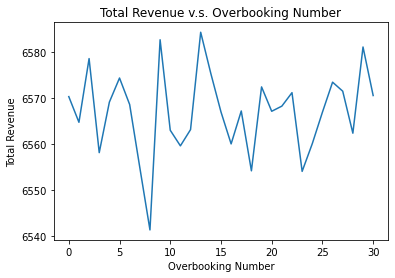

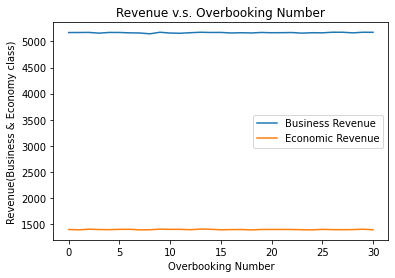

In [137]:
data_frame = result()
data_frame.get_frame(simulation_result)
print(data_frame.frame)

# Business and Economy Revenue Chart
data_frame.get_plot(simulation_result)

In [138]:
#The optimisation result

data_frame.get_max_revenue(capacity_all)
data_frame.max_revenue

Overbooking Number                13
Business Revenue           5174.5149
Economic Revenue           1409.8266
Estimated Total Revenue    6584.3415
Overbooking Percentage         4.06%
Name: 13, dtype: object